## Project 8: Eigenstate thermalization of hard-core bosons (Exact Diagonalization)

In [3]:
import numpy as np
from scipy.sparse import csr_matrix, kron, identity
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

First we define the functions we need to create the Hamiltonian describing hard-core bosons in matrix form for system size L, fixed particle number N, and energy parameters $\delta$, J and $J_2$

The Hamiltonian we want to represent is:
\begin{equation}
\begin{aligned}
H &= J \sum_j \left[c_j^{\dagger} c_{j+1} + \text{h.c.}\right] + J_2 \sum_j \left[c_j^{\dagger} c_{j+2} + \text{h.c.}\right] + J \sum_j \left(1 + \delta \cdot j\right) \left(\hat{n}_j - \frac{1}{2}\right) \left(\hat{n}_{j+1} - \frac{1}{2}\right) \\
&+ J_2 \sum_j \left(1 + \delta \cdot j\right) \left(\hat{n}_j - \frac{1}{2}\right) \left(\hat{n}_{j+2} - \frac{1}{2}\right).
\end{aligned}
\end{equation}

In [4]:
def calc_basis(L, N):
    basis = []
    ind_in_basis = dict()
    for state in range(2**L):
        if bin(state).count('1') == N:
            ind_in_basis[state] = len(basis)
            basis.append(state)
    return basis, ind_in_basis

def get_bit(number, bit_position): #calculates bit of number in position = bit_position
    # Shift the desired bit to the least significant position and mask all other bits
    return (number >> (bit_position-1)) & 1 # first position = 1

def diagonal(state, delta, J, J2, L):
    sum = 0
    # Iterate through the bits for nearest-neighbor interactions
    for j in range(1,L):
        sum += J*(1+delta*j)*(get_bit(state,j)-0.5)*(get_bit(state,j+1)-0.5)
    # Iterate through the bits for next-nearest-neighbor interactions
    for j in range(1,L-1):
        sum += J2*(1+delta*j)*(get_bit(state,j)-0.5)*(get_bit(state,j+2)-0.5)

    return sum

# kinetic part of the Hamiltonian exchanges occupation numbers iff they're not equal
# (in which case they are mapped to zero)

def flip_nn(s, j, L):
    """Flip the bits of the state s at positions j and (j+1)%L only if they're different."""
    if (get_bit(s, j) & 1) == (get_bit(s, j+1) & 1):
        return 0
    else:
        return s ^ (1 << (j-1) | 1 << j)

def flip_next_to_nn(s, j, L):
    """Flip the bits of the state s at positions j and (j+2)%L only if they're different."""
    if (get_bit(s, j) & 1) == (get_bit(s, j+2) & 1):
        return 0
    else:
        return s ^ (1 << (j-1) | 1 << (j+1))

def calc_H(L, N, delta, J, J2):
    """Determine the Hamiltonian as scipy.sparse.csr_matrix."""
    print("Generating Hamiltonian ... ", end="", flush=True)
    basis, ind_in_basis = calc_basis(L,N)
    M = len(basis)
    H_data = []
    H_inds = []
    a = 0
    for sa in basis:
        H_data.append(diagonal(sa, delta, J, J2, L)) #calculation of diagonal matrix elements 
        H_inds.append((a, a))

        for j in range(1,L-1):
            b = flip_nn(sa, j, L)
            c = flip_next_to_nn(sa,j,L)
            if b > 0: 
                H_data.append(J) #calculation of off-diagonal matrix elements 
                #H_inds.append((basis.index(flip_nn(sa, j, L)), a))
                H_inds.append((ind_in_basis[b], a))
            if c > 0 :
                H_data.append(J2)
                H_inds.append((ind_in_basis[c], a))
                
        if flip_nn(sa,L-1,L) > 0:
            H_data.append(J)
            H_inds.append((ind_in_basis[flip_nn(sa,L-1,L)],a))

        a += 1
    H_inds = np.array(H_inds)
    H_data = np.array(H_data)

    H = csr_matrix((H_data, (H_inds[:, 0], H_inds[:, 1])), shape=(M,M),dtype=complex)

    print("done", flush=True)
    return H


We now diagonalize the Hamiltonian with open b.c. to find the energy eigenvalues with parameters J = 1.0, J2 = 0.64, δ = 0.05 and L = 12,16, N = 3/4 · L

In [5]:
# Parameters
J = 1.0
J2 = 0.64
delta = 0.05
L = np.array([12, 16])
N = np.floor(L * 3 / 4).astype(int)  # Total number of particles (hardcore bosons)

print("L:", L)
print("N:", N)

L: [12 16]
N: [ 9 12]


In [6]:
Hs = {}
for i in range(len(L)):
    H = calc_H(L[i], N[i], delta, J, J2)
    Hs[L[i]] = H.toarray()

Generating Hamiltonian ... done
Generating Hamiltonian ... done


In [15]:
eigvals = {}
for l in L:
    eig_per_L = np.linalg.eigvalsh(Hs[l])
    eigvals[l] = eig_per_L

Now we define the GOE probability distribution we expect the level spacings to follow, and also a fitting function to double check if the GOE is the actual best fit.

In [48]:
def GOE(t):
    return np.pi/2*t*np.exp(-np.pi*t**2/4)

def pdf(t, a, b):
    return a/2 * t * np.exp(- b*t**2/4) 

We now plot the histogram distribution vs GOE distribution vs fit

# of eigvals:  220
cutoff:  22
new # of eigvals:  176
[3.40228364 3.6192074 ]


/var/folders/j2/38n83hh910154cw8rylx28rh0000gq/T/ipykernel_24430/1891171840.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_fit, y_fit, 'r-', lw=2, color = "blue", label = "Fit function")


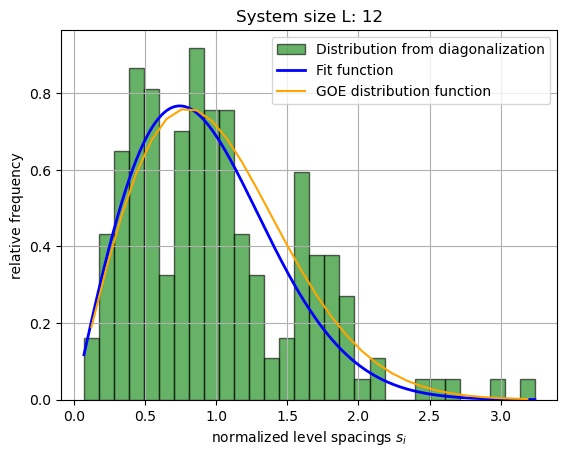

# of eigvals:  1820
cutoff:  182
new # of eigvals:  1456
[3.31632399 3.52023461]


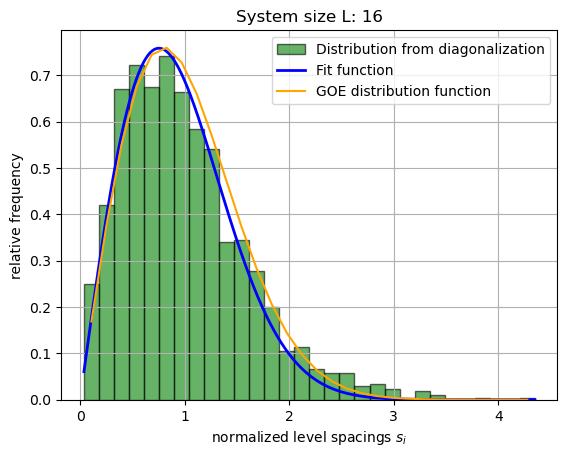

In [49]:
from scipy.optimize import curve_fit

s_datas = {}
for l in L:
    cutoff = int(0.1*len(eigvals[l]))
    print("# of eigvals: ", len(eigvals[l]))
    print("cutoff: ", cutoff)
    eigvals_new = eigvals[l][cutoff:-cutoff]
    print("new # of eigvals: ", len(eigvals_new))
    s_data = []
    for i in range(len(eigvals_new)-1):
        s_data.append((eigvals_new[i+1]-eigvals_new[i]))
        
    s_data = np.array(s_data)/np.mean(s_data)
    s_datas[l] = s_data

    plt.figure()
    entries, bin_edges, patches = plt.hist(s_data, bins=30, density= True, alpha=0.6, color='g', edgecolor='black', label = "Distribution from diagonalization")
    
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    initial_guess = [np.mean(s_data), np.std(s_data)]
    parameters, covmatrix = curve_fit(pdf, bin_centers, entries, p0= initial_guess)
    print(parameters)

    x_fit = np.linspace(min(s_data), max(s_data), 1000)
    y_fit = pdf(x_fit, *parameters)
    plt.plot(x_fit, y_fit, 'r-', lw=2, color = "blue", label = "Fit function")
    plt.plot(bin_centers, GOE(bin_centers), color='orange', label = "GOE distribution function")

    plt.xlabel('normalized level spacings $s_i$')
    plt.ylabel('relative frequency')
    plt.grid(True)
    plt.title("System size L: {}".format(l))
    plt.legend()
    plt.show()

In [24]:
print(np.mean(s_datas[12]))
print(np.mean(s_datas[16]))

1.0
1.0


ADDITIONAL GRAPHS (not inserted in the report but illustrative in the continuous case)

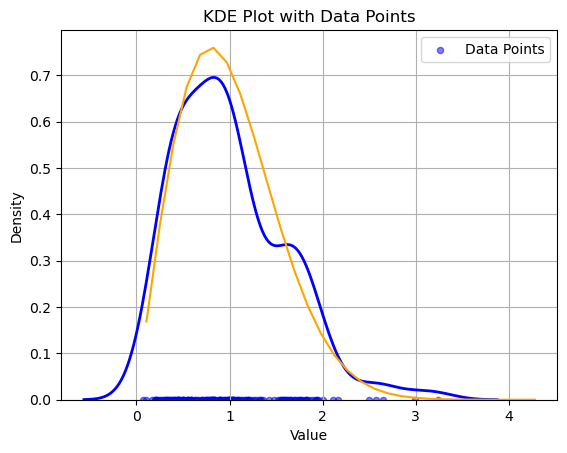

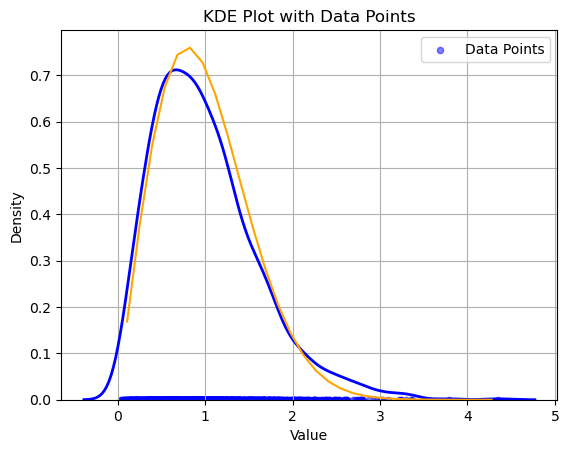

In [47]:
import seaborn as sns

for l in L:
    # Create the KDE plot
    sns.kdeplot(s_datas[l], fill=False, color='blue', lw=2)

    # Overlay dots
    plt.scatter(s_datas[l], np.zeros_like(s_datas[l]), alpha=0.5, color='blue', s=20, label='Data Points')

    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('KDE Plot with Data Points')
    plt.legend()
    plt.grid(True)
    plt.plot(bin_centers, GOE(bin_centers), color='orange', label = "GOE distribution function")

    # Show plot
    plt.show()

#poisson distribution